In [76]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import CIFAR10
from torchvision import transforms

In [77]:
dataset = CIFAR10(root="data/", download=True, transform=transforms.ToTensor())

Files already downloaded and verified


alpha_t = 1 - beta_t
alpha_t_hat = a_0 * ... * a_t
x_t = sqrt(alpha_t_hat) * x_0 + sqrt(1-alpha_t_hat) * noise

https://lilianweng.github.io/posts/2021-07-11-diffusion-models/

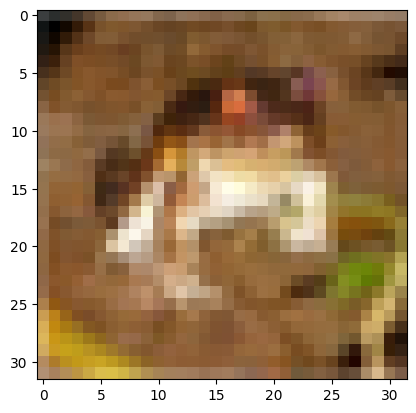

In [78]:
img = dataset[0][0].permute(1, 2, 0)
plt.imshow(img)

In [79]:
def noise_scheduler(x_0: torch.tensor, t: torch.tensor, betas: torch.tensor):
    noise = torch.rand(x_0.shape)

    alphas = 1 - betas
    alpha_hats = torch.cumprod(alphas, axis=0)

    results = torch.gather(input=alpha_hats, dim=0, index=t)
    results = torch.reshape(input=results, shape=(t.shape[0], 1, 1, 1))

    mean = results**0.5 * x_0
    variance = (1 - results) * noise

    return mean + variance

In [98]:
noise = torch.rand(img.shape)

In [99]:
t = torch.tensor([0, 1, 3])
t.shape[0]

3

In [100]:
betas = torch.tensor([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])

In [101]:
alphas = 1 - betas
alphas

tensor([0.9000, 0.8000, 0.7000, 0.6000, 0.5000, 0.4000])

In [102]:
alpha_hats = torch.cumprod(alphas, axis=0)
alpha_hats

tensor([0.9000, 0.7200, 0.5040, 0.3024, 0.1512, 0.0605])

In [103]:
results = torch.gather(input=alpha_hats, dim=0, index=t)
results

tensor([0.9000, 0.7200, 0.3024])

In [104]:
results = torch.reshape(input=results, shape=(t.shape[0], 1, 1, 1))
results.size()

torch.Size([3, 1, 1, 1])

In [105]:
img.size()

torch.Size([32, 32, 3])

In [106]:
mean = results**0.5 * img
variance = (1 - results) * noise

In [107]:
img_t = mean + variance

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


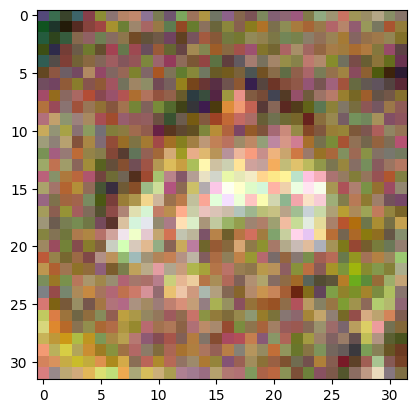

In [111]:
plt.imshow(img_t[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


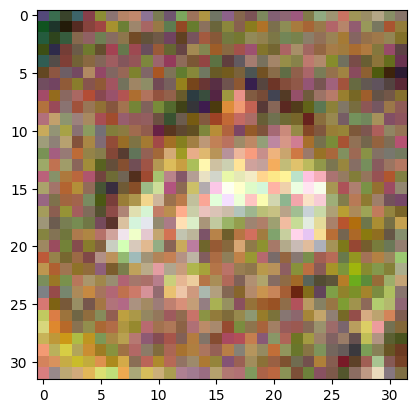

In [112]:
plt.imshow(img_t[1])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


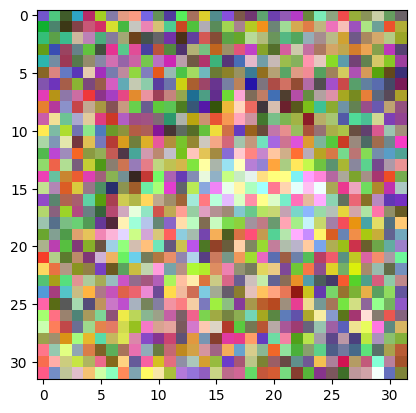

In [113]:
plt.imshow(img_t[2])